In [17]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask, smaller_dtypes
import utils

import scipy.stats
import concurrent.futures
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask.distributed import progress
from dask import delayed
from yahist import Hist1D, Hist2D

In [18]:
set_plotting_style()

## Dataframe creation

In [3]:
executor = concurrent.futures.ProcessPoolExecutor(8)

def make_df(fname,entrystart=None,entrystop=None,bigrho=True,iso=True):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["/n(DV|Jet|PV|PVM|Muon|GenMuon)$/","pass_*",
                     "/BS_(x|y|z)$/",
                     "/Muon_n(Valid|Matched|Tracker|Expected).*/",
                     "/Muon_(pt|eta|phi|m|trackIso|charge|dz.*|dxy.*|chi2|ndof|drjet|pass*)$/",
                     "/DV_(chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|pass*)$/",
                     "run","luminosityBlock","event",
                     "dimuon_*","cosphi*","absdphi*","minabs*","logabs*",
                     "L1_*",
                    ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    # booleans for selection
    if iso:
        sel = arrs["pass_baseline_iso"]
    else:
        sel = arrs["pass_baseline"]
    
    if bigrho:
        sel = sel & (arrs["DV_rho"]>1.0).any()

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event","L1_",
                                        "dimuon","cosphi","absdphi","minabs","logabs"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],df["Muon1_m"])
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],df["Muon2_m"])
    df["dimuon_deltaeta"] = np.abs(mu1.eta - mu2.eta)
    df["dimuon_deltar"] = mu1.delta_r(mu2)
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    
    # category 1: any L1s, dR(mumu)<1.2
    # category 2: at least the L1_15_7 bit, dR(mumu)>1.2, and pT>15/7
    df["categ"] = df.eval("   1*(dimuon_deltar<1.2) "
                          " + 2*(dimuon_deltar>1.2 and L1_DoubleMu_15_7 and Muon1_pt>15 and Muon2_pt>7)").astype(int)
    
    df["Muon1_excesshits"] = df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits")
    df["Muon2_excesshits"] = df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")
    df["pass_excesshits"] = df.eval("DV_rhoCorr<3.5 or (Muon1_excesshits<=0 and Muon2_excesshits<=0)")
    
    for name,dtype in smaller_dtypes:
        if name not in df.columns: continue
        df[name] = df[name].astype(dtype, copy=False)
    return df

def make_df_noiso(x):
    return make_df(x, iso=False)

fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v10//output_1.root")
futures_mc = executor.map(make_df_noiso, fnames_mc)
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_unblind1fb_RAW_v10skim1cm/*.root")
futures_data = executor.map(make_df_noiso, fnames_data)
df_data = pd.concat(tqdm(futures_data,total=len(fnames_data))).reset_index(drop=True)
df_mc = pd.concat(tqdm(futures_mc,total=len(fnames_mc))).reset_index(drop=True)

del executor

In [4]:
df_data.to_pickle("data/df_data_noiso.pkl")
df_mc.to_pickle("data/df_mc_noiso.pkl")

df_data.query("pass_baseline_iso").to_pickle("data/df_data.pkl")
df_mc.query("pass_baseline_iso").to_pickle("data/df_mc.pkl")

In [5]:
# NOTE, no iso is applied in the df. need to require pass_iso at event level

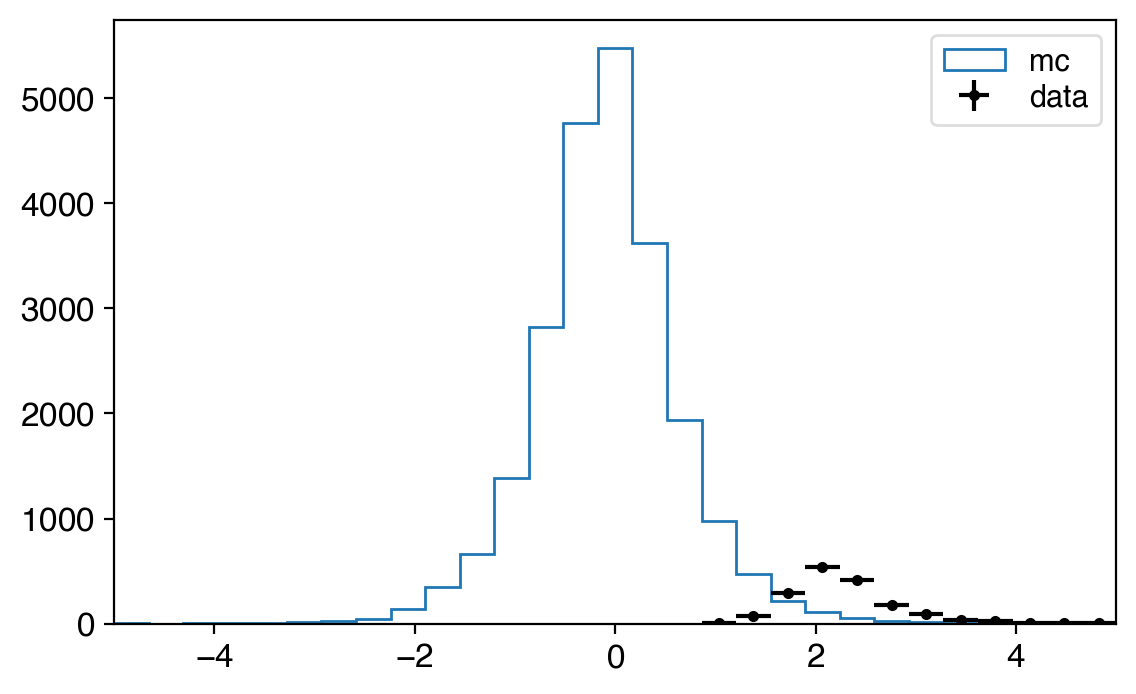

In [6]:
fig, ax = plt.subplots()
bins = np.linspace(-5,5,30)
varexp = "logabsetaphi"
sel = "(dimuon_mass>5)"
df_mc.tree.draw(varexp,sel,bins=bins).plot(ax=ax,label="mc",histtype="step")
df_data.tree.draw(varexp,sel,bins=bins).plot(ax=ax,label="data",show_errors=True,color="k",ms=3)
# df_mc.tree.draw(varexp,sel+" and pass_iso",bins=bins).plot(ax=ax,label="mc",histtype="step")
# df_data.tree.draw(varexp,sel+" and pass_iso",bins=bins).plot(ax=ax,label="data",show_errors=True,color="r",ms=3)
ax.legend()

In [7]:
print(df_data.shape)
print(df_mc.shape)
df_mc.head()

(150883, 89)
(23145, 89)


,nDV,nJet,nPV,nPVM,nMuon,nGenMuon,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,...,L1_DoubleMu4p5_SQ_OS_dR_Max1p2,L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4,L1_DoubleMu_15_7,dimuon_deltaeta,dimuon_deltar,DV_xyErrorMax,categ,Muon1_excesshits,Muon2_excesshits,pass_excesshits
0,1,3,13,4,2,2,True,True,True,True,...,True,False,True,0.277841,0.869605,0.007805,1,-3,-2,True
1,1,0,8,2,2,2,True,True,True,True,...,False,False,True,1.310411,1.531894,0.002032,0,-1,-1,True
2,1,2,10,2,2,2,True,True,True,True,...,True,False,True,0.940181,0.962775,0.001319,1,0,0,True
3,1,0,12,2,2,2,True,True,True,True,...,True,True,True,0.255480,0.664894,0.002429,1,0,-1,True
4,1,1,2,1,2,2,True,True,True,True,...,False,True,False,0.018492,1.446627,0.002416,0,0,-1,True


## Plot dump

In [8]:
# nevents = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v9//output_1.root")["nevents_processed"]._fVal

In [61]:
plotdir = "plots_scouting_massgt5_maybeiso_v2"
os.system("mkdir -p {}".format(plotdir))

globalsel = "dimuon_mass>5 and pass_baseline_iso"
normalize = True

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    [r"dimuon $p_T$<20",lambda df:  np.abs(df["dimuon_pt"])<20],
    [r"dimuon $p_T$>20",lambda df: np.abs(df["dimuon_pt"])>20],
],split_label = "splitpt"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"DV $\rho$ 1-3cm",lambda df:  (np.abs(df["DV_rhoCorr"])<3.0) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"DV $\rho$ 3-11cm",lambda df:  (np.abs(df["DV_rhoCorr"])<11.0) & (np.abs(df["DV_rhoCorr"])>3.0)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["5<mass<15",lambda df:  (df["dimuon_mass"]<15) & (df["dimuon_mass"]>5)],
    ["mass>15",lambda df:  (df["dimuon_mass"]>15)],
],split_label = "splitmass"))

selinfos.append(dict(vsels=[
    ["passiso",lambda df:  (df["pass_baseline_iso"])],
    ["failiso",lambda df:  (~df["pass_baseline_iso"])],
],split_label = "splitiso"))

plotinfos = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    [[lambda df: df["Muon1_nValidStripHits"],lambda df: df["Muon2_nValidStripHits"]], np.arange(30)-0.5, dict(title="Muon nValidStripHits",shortname="nValidStripHits")],
    
    [[lambda df: df["Muon1_nExpectedPixelHits"],lambda df: df["Muon2_nExpectedPixelHits"]], np.arange(12)-0.5, dict(title="Muon nExpectedPixelHits",shortname="nExpectedPixelHits")],
    [[lambda df: df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),lambda df: df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")], np.arange(10)-5.5, dict(title="Muon n(Valid-Expected)PixelHits",shortname="nValidMinusExpectedPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(7)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(60)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,50), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,50), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,50), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,logx=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["minabsdxy"]], np.linspace(-6,6,150), dict(title="min(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="minabsdxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df.eval("Muon1_chi2/Muon1_ndof"),lambda df: df.eval("Muon1_chi2/Muon1_ndof")], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,0.1,50), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    [[lambda df: df["Muon1_drjet"],lambda df: df["Muon2_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(muon,closest jet)",shortname="drjet")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="In pixel volumes?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho (logscale)",logy=True,shortname="rholog")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho",logy=False,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2)), logscale",logx=True,logy=True,shortname="dphimumulog")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.03,50), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,80), dict(title="Dimuon mass",logy=False,logx=False,shortname="mass")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,36), dict(title="Dimuon mass (logscale)",logy=True,logx=False,shortname="masslog")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    
    [[lambda df: df["DV_zError"]], np.linspace(0.0,0.1,50), dict(title="DV zError",shortname="zError")],
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.05,50), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df.eval("DV_chi2/DV_ndof")], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    [[lambda df: df["nJet"]], np.arange(15)-0.5, dict(title="nJet",shortname="njets")],
    
    [[lambda df: df["dimuon_deltar"]], np.linspace(0,5,50), dict(title="$\Delta$R(mu1,mu2)",shortname="drmumu")],
    
    [[lambda df: df["logabsetaphi"]], np.linspace(-10,10,50), dict(title="log(abs($\Delta\eta_{12}/\Delta\phi_{12}$))",shortname="logabsetaphi")],
    [[lambda df: df["categ"]], np.linspace(-0.5,2.5,4), dict(title="category (1=any,dR<1.2; 2=L1_15_7,dR>1.2)",shortname="category")],
    
]

# plotinfos = [
# ]

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plotinfos:
        fig,ax = plt.subplots()

        ymax = 0.
        datanorms = {}
        for df,label,linestyle in [
            [df_data,"Data","-"],
            [df_mc,"Signal","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "Signal") and (("mass<5" in sel_label) or ("mass<15" in sel_label)): continue
                    
                if globalsel:
                    if "splitiso" in split_label:
                        sel = globalsel.replace("and pass_baseline_iso","")
                    else:
                        sel = globalsel[:]
                    df = df.query(sel)
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs])
                if normalize:
                    h = h.normalize()
                else:
                    if "signal" in label.lower():
                        h *= (datanorms[sel_label]/h.counts.sum())
                        label = r"Signal (norm. to data)"
#                         h *= sigweight
#                         label = r"Signal ($\sigma$={:g}pb)".format(xsec/1000)
                if label == "Data":
                    datanorms[sel_label] = h.counts.sum()
#                     h.plot(ax=ax,label="{} ({})".format(label,sel_label),color="k",show_errors=True,markersize=2.5);
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,show_errors=True,markersize=2.5);
                else:
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ax.text(0.99, 1.01,"2018C, 1 fb${}^\mathregular{-1}$", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="large")
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_xlabel(opts.get("xlabel",""),horizontalalignment="right",x=1.)
        ylabel = "Frac. of events" if normalize else "Events"
        ax.set_ylabel(opts.get("ylabel",ylabel),horizontalalignment="right",y=1.)
        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=125)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

plots_scouting_massgt5_maybeiso_v2/splitnone_nValidPixelHits.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nValidStripHits.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nExpectedPixelHits.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nValidMinusExpectedPixelHits.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nTrackerLayers.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nMatchedStations.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nValidMuonHits.png
plots_scouting_massgt5_maybeiso_v2/splitnone_eta.png
plots_scouting_massgt5_maybeiso_v2/splitnone_phi.png
plots_scouting_massgt5_maybeiso_v2/splitnone_pt.png
plots_scouting_massgt5_maybeiso_v2/splitnone_absdxy.png
plots_scouting_massgt5_maybeiso_v2/splitnone_signeddxy.png
plots_scouting_massgt5_maybeiso_v2/splitnone_minabsdxy.png
plots_scouting_massgt5_maybeiso_v2/splitnone_dxyError.png
plots_scouting_massgt5_maybeiso_v2/splitnone_Muonchi2.png
plots_scouting_massgt5_maybeiso_v2/splitnone_trackIso.png
plots_scouting_massgt5_m

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


plots_scouting_massgt5_maybeiso_v2/splitnone_rholog.png
plots_scouting_massgt5_maybeiso_v2/splitnone_rho.png
plots_scouting_massgt5_maybeiso_v2/splitnone_dphimumu.png
plots_scouting_massgt5_maybeiso_v2/splitnone_dphimumulog.png
plots_scouting_massgt5_maybeiso_v2/splitnone_dphimudv.png
plots_scouting_massgt5_maybeiso_v2/splitnone_mass.png
plots_scouting_massgt5_maybeiso_v2/splitnone_masslog.png
plots_scouting_massgt5_maybeiso_v2/splitnone_dimuonpt.png
plots_scouting_massgt5_maybeiso_v2/splitnone_zError.png
plots_scouting_massgt5_maybeiso_v2/splitnone_xyErrorMax.png
plots_scouting_massgt5_maybeiso_v2/splitnone_DVchi2.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nPV.png
plots_scouting_massgt5_maybeiso_v2/splitnone_nPVM.png
plots_scouting_massgt5_maybeiso_v2/splitnone_njets.png
plots_scouting_massgt5_maybeiso_v2/splitnone_drmumu.png
plots_scouting_massgt5_maybeiso_v2/splitnone_logabsetaphi.png
plots_scouting_massgt5_maybeiso_v2/splitnone_category.png
plots_scouting_massgt5_maybeiso_v2/

plots_scouting_massgt5_maybeiso_v2/splitmass_dphimumulog.png
plots_scouting_massgt5_maybeiso_v2/splitmass_dphimudv.png
plots_scouting_massgt5_maybeiso_v2/splitmass_mass.png
plots_scouting_massgt5_maybeiso_v2/splitmass_masslog.png
plots_scouting_massgt5_maybeiso_v2/splitmass_dimuonpt.png
plots_scouting_massgt5_maybeiso_v2/splitmass_zError.png
plots_scouting_massgt5_maybeiso_v2/splitmass_xyErrorMax.png
plots_scouting_massgt5_maybeiso_v2/splitmass_DVchi2.png
plots_scouting_massgt5_maybeiso_v2/splitmass_nPV.png
plots_scouting_massgt5_maybeiso_v2/splitmass_nPVM.png
plots_scouting_massgt5_maybeiso_v2/splitmass_njets.png
plots_scouting_massgt5_maybeiso_v2/splitmass_drmumu.png
plots_scouting_massgt5_maybeiso_v2/splitmass_logabsetaphi.png
plots_scouting_massgt5_maybeiso_v2/splitmass_category.png
plots_scouting_massgt5_maybeiso_v2/splitiso_nValidPixelHits.png
plots_scouting_massgt5_maybeiso_v2/splitiso_nValidStripHits.png
plots_scouting_massgt5_maybeiso_v2/splitiso_nExpectedPixelHits.png
plots_s

In [62]:
with open("{}/description.txt".format(plotdir),"w") as fh:
    fh.write("""
Baseline selection: 
<ul>
<li>==2 OS muons, ==1 DV</li>
<li>1cm < DV rho < 11cm</li>
<li>cos(dphi(dimuon,DV))>0</li>
<li>max(DV_xError,yError)<0.05cm, DV_zError<0.1cm</li>
<li>valid muon hits>0 for each muon</li>
<li>tracker layers with measurement>5 for each muon</li>
<li>|dphi(mu1,mu2)|<2.8</li>
<li>|dphi(dimuon,DV)| < 0.02</li>
<li>Muon chi2/ndof < 3</li>
<li>DV chi2/ndof < 5</li>
<li>Muon trackIso < 0.1 for each muon (<i>isolation</i>)</li>
<li>dR(muon,closest jet) > 0.3 for each muon (<i>isolation</i>)</li>
</ul>
Note, isolation criteria relaxed for plots split by iso. Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>DV rho ("splitrho_")</li>
<li>pt of dimuon system ("splitpt_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>mass of dimuon system ("splitmass_")</li>
<li>category ("splitcateg_")</li>
<li>iso ("splitiso_")</li>
</ul>
    """)

!niceplots {plotdir}
print(f"http://uaf-10.t2.ucsd.edu/~namin/dump/plots/{plotdir}/")

Not converting anything
ln: creating symbolic link `plots_scouting_massgt5_maybeiso_v2/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_scouting_massgt5_maybeiso_v2/
http://uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_scouting_massgt5_maybeiso_v2/


## Muon checks

In [9]:
# df_data = pd.read_pickle("data/df_data_allrho.pkl")
# df_mc = pd.read_pickle("data/df_mc_allrho.pkl")

In [10]:
# sel1 = "dimuon_mass>5 and (not Muon1_passiso) and Muon1_pt<15 and abs(Muon1_eta)<0.9"
# sel2 = "dimuon_mass>5 and (not Muon2_passiso) and Muon2_pt<15 and abs(Muon1_eta)<0.9"
# # df = df_data

# # sel1 = "dimuon_mass>5 and Muon1_pt<15 and abs(Muon1_eta)<0.9"
# # sel2 = "dimuon_mass>5 and Muon2_pt<15 and abs(Muon1_eta)<0.9"
# # df = df_mc

# # h = Hist2D(
# #     pd.concat([
# x = df.query(sel1)[["Muon1_nMatchedStations","Muon1_nValidMuonHits"]].values.compute()
# x
# # y = df.query(sel2)[["Muon2_nMatchedStations","Muon2_nValidMuonHits"]]
# #     ],sort=True).values,

In [11]:
# # sel1 = "dimuon_mass>5 and (not Muon1_passiso) and Muon1_pt<15 and abs(Muon1_eta)<0.9"
# # sel2 = "dimuon_mass>5 and (not Muon2_passiso) and Muon2_pt<15 and abs(Muon1_eta)<0.9"

# sel1 = "DV_rhoCorr>1 and (not Muon1_passiso) and Muon1_pt<15 and abs(Muon1_eta)<0.9"
# sel2 = "DV_rhoCorr>1 and (not Muon2_passiso) and Muon2_pt<15 and abs(Muon1_eta)<0.9"
# # df = df_data

# # sel1 = "dimuon_mass>5 and Muon1_pt<15 and abs(Muon1_eta)<0.9"
# # sel2 = "dimuon_mass>5 and Muon2_pt<15 and abs(Muon1_eta)<0.9"
# # df = df_mc

# h = Hist2D(
#     pd.concat([
#         df.query(sel1)[["Muon1_nMatchedStations","Muon1_nValidMuonHits"]].compute(),
#         df.query(sel2)[["Muon2_nMatchedStations","Muon2_nValidMuonHits"]].compute(),
#     ],sort=True).values,
#     bins = [np.arange(-0.5,5.5),np.arange(-0.5,55.5,1)],
# )
# # h.plot(cmap="binary")
# # h.plot(logz=True)
# fig, ax = plt.subplots()
# ax.grid()
# h.plot(ax=ax,cmap="Reds")

# ax.set_title("Data")
# # ax.set_title("MC")
# ax.set_xlabel("nMatchedStations")
# ax.set_ylabel("nValidMuonHits")


In [12]:
# df = df_mc
# selstr ="pass_iso and dimuon_mass>5 and DV_rhoCorr>3"
# df = df.query(selstr)
# excess = np.maximum(
#     df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),
#     df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits"),
#           )
# magic = df["logabsetaphi"]

# fig, ax = plt.subplots()
# h = Hist2D(
#     np.c_[excess,magic],
#     bins = [np.arange(-1.5,4.5),np.linspace(-4,4,20)],
# )
# h.plot(ax=ax,cmap="Reds",logz=False,label="MC")

# df = df_data
# df = df.query("pass_iso and dimuon_mass>5 and DV_rhoCorr>3")
# excess = np.maximum(
#     df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),
#     df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits"),
#           )
# magic = df["logabsetaphi"]

# ax.scatter(
#     excess,magic,color="k",
#     label="Data"
# )

# ax.set_title(selstr)
# ax.set_xlabel("obs-exp hits")
# ax.set_ylabel("logabsetaphi")

# ax.legend()

In [204]:
# len(df)

## Dask, full plots

In [19]:
client = Client("tcp://169.228.130.74:11303")
# client.restart()
client

Client Scheduler: tcp://169.228.130.74:11303 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 72 Cores: 72 Memory: 288.00 GB


In [20]:
def make_df_fast(fname,entrystart=None,entrystop=None):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["pass_*",
                     "/Muon_n(Valid|Expected).*/",
                     "/Muon_(dxyCorr)$/",
                     "/DV_(rhoCorr|x|y)$/",
                     "run","luminosityBlock","event",
                     "/dimuon_(mass|pt)/","minabs*","logabs*",
                    ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    # booleans for selection
    sel = arrs["pass_baseline"]

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event","L1_",
                                        "dimuon","cosphi","absdphi","minabs","logabs"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    df["pass_excesshits"] = df.eval("DV_rhoCorr<3.5 or ((Muon1_nValidPixelHits-Muon1_nExpectedPixelHits)<=0 and (Muon2_nValidPixelHits-Muon2_nExpectedPixelHits)<=0)")
    
    # minabsdxy > k*rho*mass*ptmm (k~0.1?) could help recover eff at low signal masses
    df["dxythresh"] = df.eval("0.1 * DV_rhoCorr * dimuon_mass / dimuon_pt")
    df["dxyratio"] = df.eval("minabsdxy / dxythresh")
    
    for name,dtype in smaller_dtypes:
        if name not in df.columns: continue
        df[name] = df[name].astype(dtype, copy=False)
    return df


In [21]:
@delayed
def make_df_delayed(chunk):
#     return make_df(*chunk, bigrho=False, iso=False)
    return make_df_fast(*chunk)

In [22]:
# # this is 1fb unblinded 2018C
# fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_unblind1fb_RAW_v10/*.root")

# FIXME this is full 2018C
fnames_data = glob.glob(
    "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_RAW_v10/*.root"
)

fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v10//output_1.root")

print(len(fnames_data))

chunks, total_events = utils.get_chunking_dask(tuple(fnames_data),400e3,client=client,skip_bad_files=True,xrootd=False)
len(chunks)

197


1207

In [23]:
meta = make_df_delayed([chunks[0][0],0,5000]).compute()
meta.head()

,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,Muon1_nValidMuonHits,Muon2_nValidMuonHits,Muon1_nValidPixelHits,Muon2_nValidPixelHits,...,run,luminosityBlock,event,dimuon_pt,dimuon_mass,minabsdxy,logabsetaphi,pass_excesshits,dxythresh,dxyratio
0,True,True,True,True,True,True,24,12,4,5,...,319337,48,10738734,6.785450,3.521773,0.115305,-0.335063,True,0.014350,8.035211
1,True,True,True,True,True,True,36,24,7,3,...,319337,48,10743671,9.995001,2.357998,0.055473,-0.178866,True,0.009441,5.875481
2,True,True,True,True,True,False,32,28,4,3,...,319337,48,10848338,10.047926,3.105935,0.034845,0.046681,True,0.007893,4.414864
3,True,True,True,True,True,False,46,49,4,3,...,319337,49,10922775,16.297968,1.017036,0.009408,-0.165725,True,0.001579,5.958049
4,True,True,True,True,True,True,33,33,4,2,...,319337,49,12145275,13.403290,3.328078,0.023262,0.043328,True,0.003841,6.055838


In [24]:
dataremotedf = (dd
      .from_delayed((make_df_delayed(chunk) for chunk in chunks),meta=meta)
      .repartition(npartitions=len(chunks)//10)
      .persist()
)

progress(dataremotedf)

VBox()

In [212]:
chunks, total_events = utils.get_chunking_dask(tuple(fnames_mc),500e3,client=client)
print(len(chunks))
mcremotedf = dd.from_delayed((make_df_delayed(chunk) for chunk in chunks),meta=meta).persist()

progress(mcremotedf)

1


VBox()

In [14]:
client.cancel(dataremotedf)
client.cancel(mcremotedf)

In [213]:
save_locally = False
if save_locally:
    print(len(dataremotedf))
    print((dataremotedf.memory_usage().sum()/1e6).compute())
    datalocaldf = dataremotedf.compute()
    datalocaldf.to_pickle("data/df_data_allrho_noiso.pkl")
    datalocaldf.query("pass_baseline_iso").to_pickle("data/df_data_allrho.pkl")
    datalocaldf.query("pass_baseline_iso and DV_rho>1.0").to_pickle("data/df_data.pkl")
    del datalocaldf
    
    mclocaldf = mcremotedf.compute()
    mclocaldf.to_pickle("data/df_mc_allrho_noiso.pkl")
    mclocaldf.query("pass_baseline_iso").to_pickle("data/df_mc_allrho.pkl")
    mclocaldf.query("pass_baseline_iso and DV_rho>1.0").to_pickle("data/df_mc.pkl")
    del mclocaldf
    
    !ssh uafino.physics.ucsb.edu ./syncdataframes.sh

In [214]:
%%time
def get_ranges(df):
    return tuple(df[["start","end"]].values)
def is_good(run,lumi):
    return any(low<=lumi<=high for low,high in lut.get(run,[(0,0)]))
lut = pd.read_csv("../batch/test/combined_run2_snt.csv").groupby("run").apply(get_ranges)
lut

CPU times: user 1.05 s, sys: 44 ms, total: 1.1 s
Wall time: 981 ms


run
273158               ([1, 1279],)
273302                ([1, 459],)
273402              ([100, 292],)
273403                 ([1, 53],)
273404                 ([1, 18],)
                   ...           
325159               ([48, 266],)
325168                 ([1, 21],)
325169                 ([1, 23],)
325170    ([1, 692], [694, 1205])
325172     ([1, 267], [269, 485])
Length: 1345, dtype: object

0


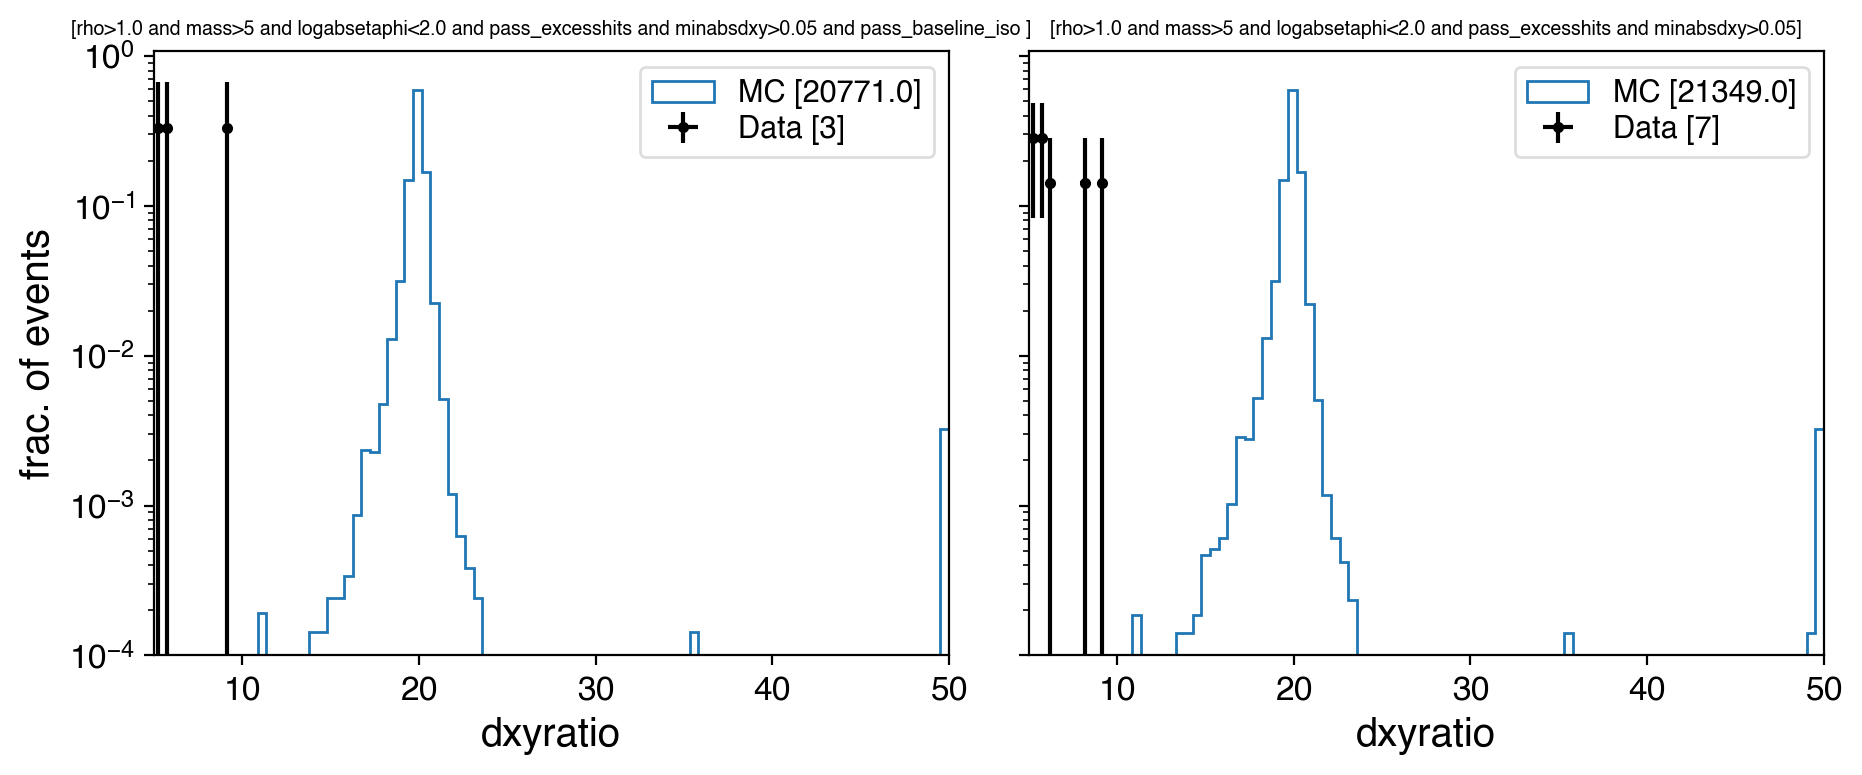

In [232]:
basesel = "DV_rhoCorr>1.0 and dimuon_mass>5"
basecount = mcremotedf.eval(basesel).sum().compute()

extrasel = " and ".join([
    "logabsetaphi<2.0",
#     "logabsetaphi<1.0",
#     "noexcesshits",
#     "noexcesshitslay1",
    "pass_excesshits",
#     "leq1excesshits",
    "minabsdxy>0.05",
#     "dxyratio>0.8"
])

sel = basesel + " and " + extrasel
sel_iso = sel + " and pass_baseline_iso "

varexp = "dimuon_mass"
bins = np.linspace(5.0,50,92+1)

# varexp = "dxyratio"
# bins = np.linspace(0.0,6.0,50)

def clip(x):
    return da.clip(x, bins[0]+1e-6, bins[-1]-1e-6)

mc1 = mcremotedf.query(sel)
mc1_iso = mc1.query("pass_baseline_iso")
data1 = dataremotedf.query(sel)
data1_iso = data1.query("pass_baseline_iso")

counts_mc, counts_mc_iso, counts_data, counts_data_iso = client.compute([
    da.histogram(clip(mc1.eval(varexp)),bins=bins)[0],
    da.histogram(clip(mc1_iso.eval(varexp)),bins=bins)[0],
    da.histogram(clip(data1.eval(varexp)),bins=bins)[0],
    da.histogram(clip(data1_iso.eval(varexp)),bins=bins)[0],
],sync=True)

hmc = Hist1D.from_bincounts(counts_mc,bins,errors=counts_mc**0.5)
hdata = Hist1D.from_bincounts(counts_data,bins,errors=counts_data**0.5)
hmc_iso = Hist1D.from_bincounts(counts_mc_iso,bins,errors=counts_mc_iso**0.5)
hdata_iso = Hist1D.from_bincounts(counts_data_iso,bins,errors=counts_data_iso**0.5)

num_not_in_json = (~data1_iso[["run","luminosityBlock"]].compute().apply(lambda x: is_good(*x), axis=1)).sum()
print(num_not_in_json)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)

def decorate(ax,iso=True):
#     ax.set_title("sel=({}) [{:.1f}% MC wrt rho>1,mass>5{}]".format(extrasel,100.*hmc.integral/basecount,
#     ax.set_title("sel=({}) [{:.1f}% MC]".format(extrasel,100.*hmc.integral/basecount,
#                                                                   ",iso" if iso else ""),fontsize=8)
    selstr = "[{}]".format(sel_iso if iso else sel)
    selstr = selstr.replace("DV_rhoCorr","rho").replace("dimuon_mass","mass")
    ax.set_title(selstr,fontsize=7)
#     ax.set_xlabel("dimuon mass (GeV)")
    ax.set_xlabel("dxyratio")
    if iso:
        ax.set_ylabel("frac. of events")
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.0001)
    
ax = ax1
hmc_iso.normalize().plot(ax=ax,histtype="step",label="MC [{:.1f}]".format(hmc_iso.integral))
hdata_iso.normalize().plot(ax=ax,show_errors=True,color="k",markersize=3,label="Data [{:.0f}]".format(hdata_iso.integral))
decorate(ax,iso=True)


ax = ax2
hmc.normalize().plot(ax=ax,histtype="step",label="MC [{:.1f}]".format(hmc.integral))
hdata.normalize().plot(ax=ax,show_errors=True,color="k",markersize=3,label="Data [{:.0f}]".format(hdata.integral))
decorate(ax,iso=False)

# fig.set_tight_layout(True)


In [233]:
df

,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,Muon1_nValidMuonHits,Muon2_nValidMuonHits,Muon1_nValidPixelHits,Muon2_nValidPixelHits,...,DV_x,DV_y,DV_rhoCorr,run,luminosityBlock,event,dimuon_mass,minabsdxy,logabsetaphi,pass_excesshits
0,True,True,True,True,True,True,24,12,4,5,...,0.109835,-0.161349,0.276482,319337,48,10738734,3.521773,0.115305,-0.335063,True
1,True,True,True,True,True,True,36,24,7,3,...,0.119387,-0.284734,0.400203,319337,48,10743671,2.357998,0.055473,-0.178866,True
2,True,True,True,True,True,False,32,28,4,3,...,0.092860,-0.140513,0.255331,319337,48,10848338,3.105935,0.034845,0.046681,True
3,True,True,True,True,True,False,46,49,4,3,...,0.268279,-0.250568,0.253036,319337,49,10922775,1.017036,0.009408,-0.165725,True
4,True,True,True,True,True,True,33,33,4,2,...,0.037756,0.078041,0.154702,319337,49,12145275,3.328078,0.023262,0.043328,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19621,True,True,True,True,True,True,20,8,4,3,...,0.028073,-0.082074,0.069811,319337,80,61521541,0.793044,0.002492,-0.226333,True
19622,True,True,True,True,True,False,37,30,4,3,...,-0.782797,0.209985,0.920714,319337,80,62727258,2.516399,0.001229,2.044439,True
19623,True,True,True,True,True,True,20,23,4,4,...,0.084959,-0.034093,0.032977,319337,80,61205457,3.256937,0.005018,-0.126875,True
19624,True,True,True,True,True,False,20,22,4,4,...,0.279088,-0.066902,0.183274,319337,80,61244674,1.518766,0.006249,-0.386158,True


In [270]:
arr = uproot.daskarray(
    "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_RAW_v10/output_9.root",
    "Events",
    "pass_baseline_iso",
    entrysteps=int(300e3),
)
arr

dask.array<array, shape=(2520235,), dtype=float64, chunksize=(2520235,), chunktype=awkward.ChunkedArray>

In [279]:
# da.histogram(arr,bins=np.linspace(0,2,3))[0].compute()
da.mean(arr[:3])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [281]:
arr.chunks

((2520235,),)

In [287]:
arr = da.array(mcremotedf["pass_skim"])

In [291]:
mcremotedf["pass_skim"].mean().compute()

ValueError: Inputs contain futures that were created by another client.